<h2 style="color:blue" align="center">Quantization Tutorial</h2>

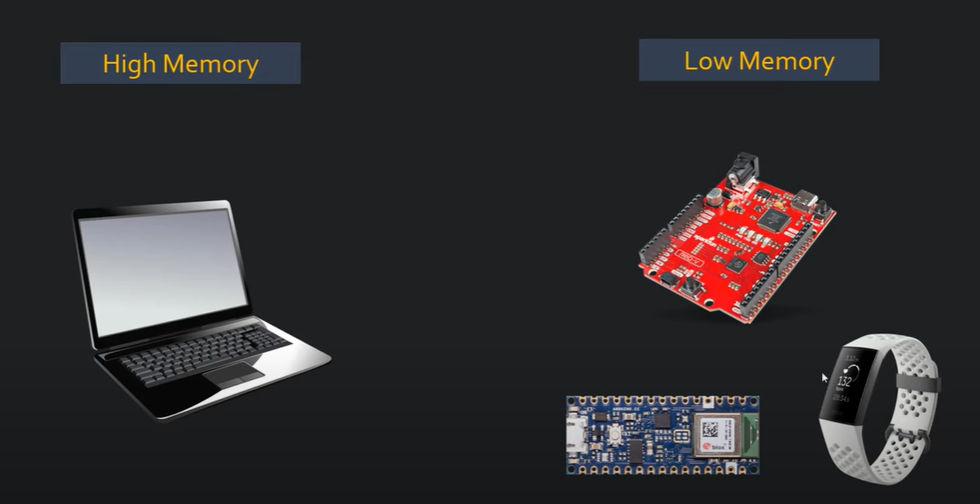

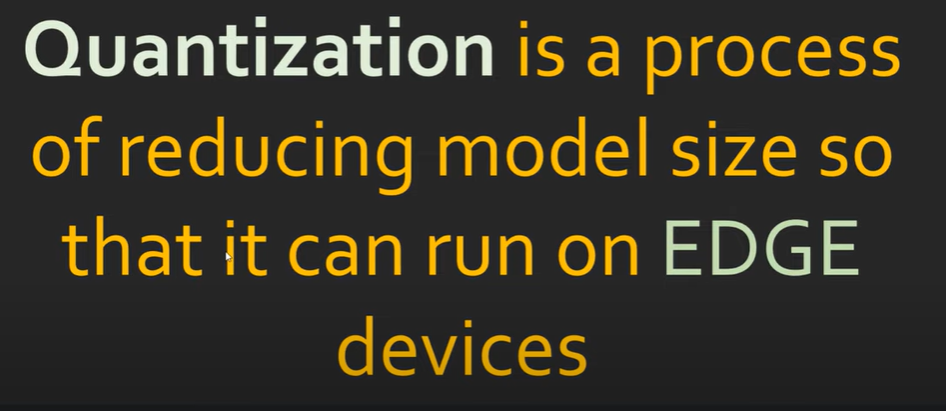

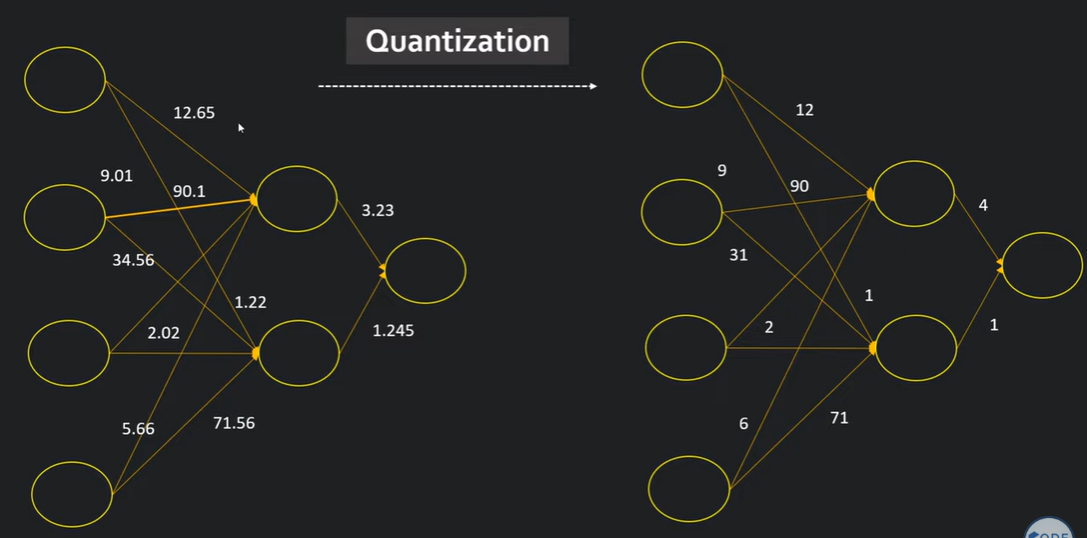

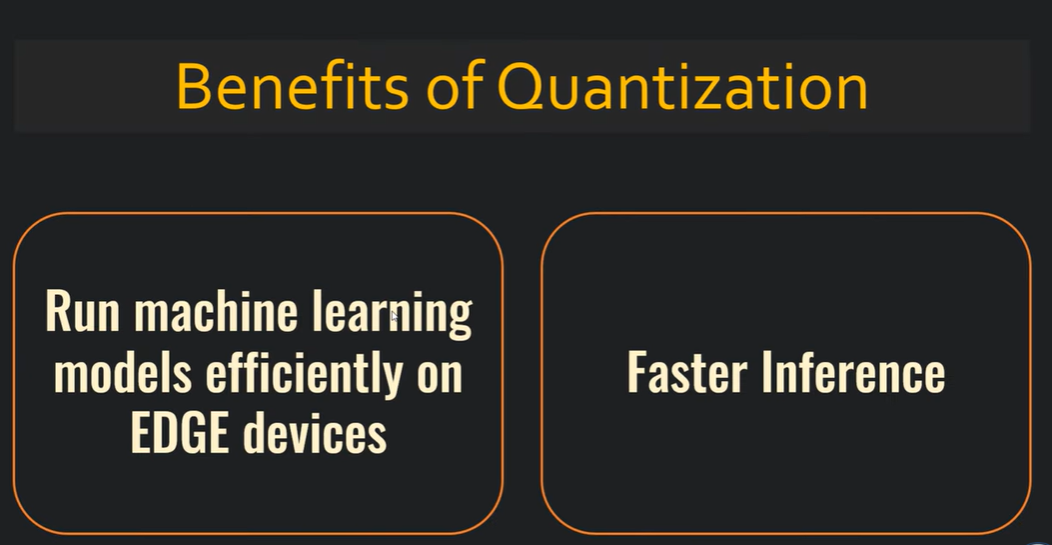

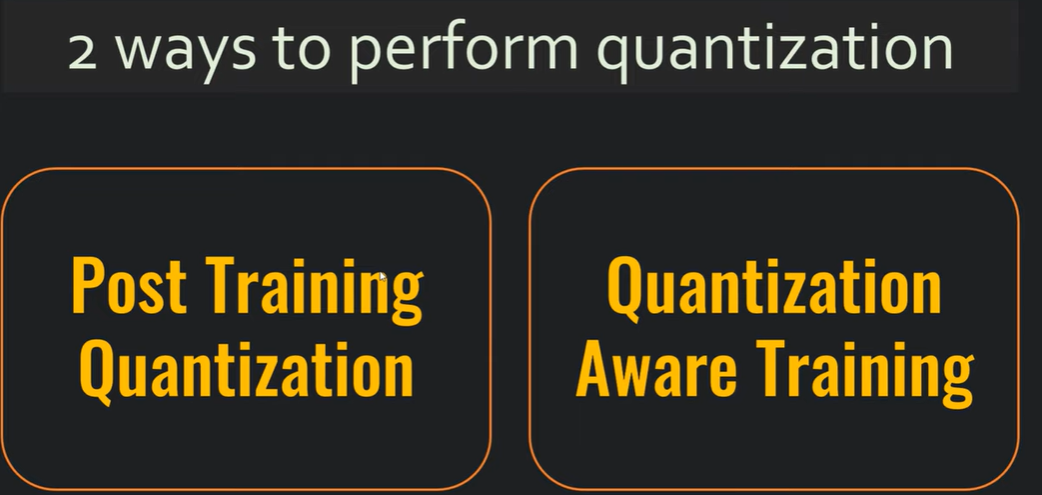

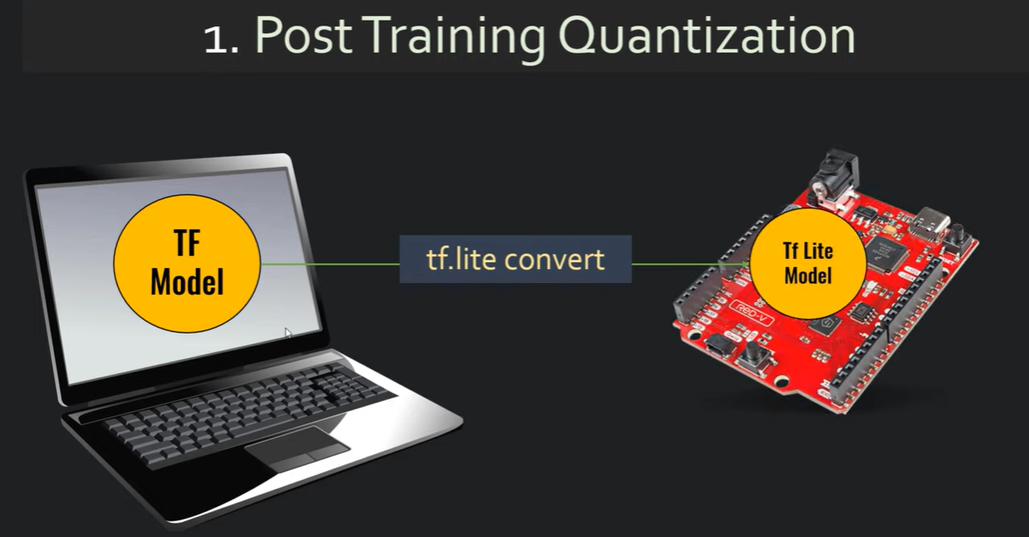

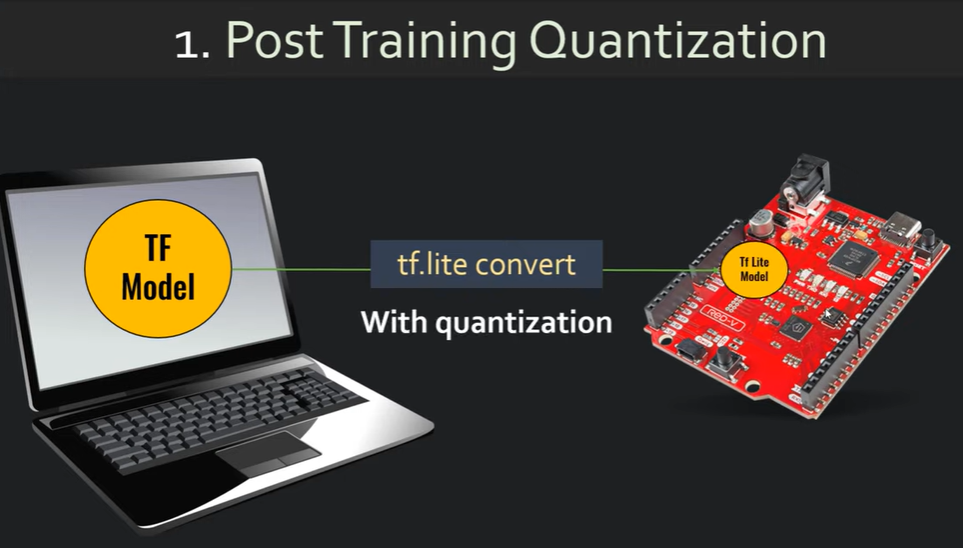

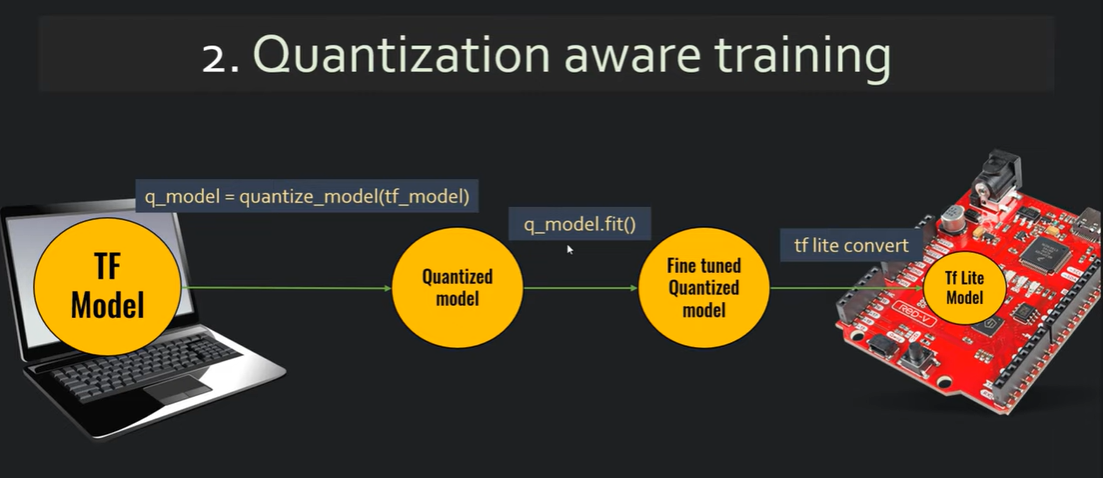

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
len(X_train)

60000

In [ ]:
len(X_test)

10000

In [ ]:
X_train[0].shape

(28, 28)

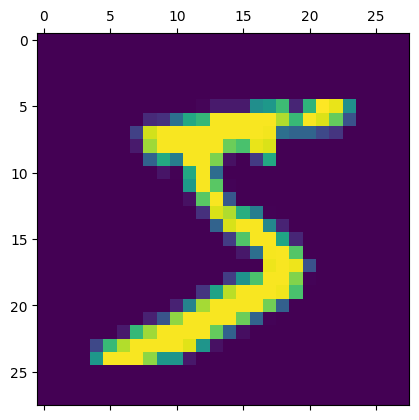

In [ ]:
plt.matshow(X_train[0])

In [ ]:
y_train[0]

5

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [ ]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8725 - loss: 0.4478
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9600 - loss: 0.1332
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9735 - loss: 0.0898
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9802 - loss: 0.0659
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9851 - loss: 0.0515


In [ ]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9731 - loss: 0.0906


[0.07786405086517334, 0.9764000177383423]

In [ ]:
model.save("./saved_model/my_model.h5")

<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [ ]:
# Load the saved Keras model
model = tf.keras.models.load_model("./saved_model/my_model.h5")

# Create a TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Pass the model object instead of file path

# Convert the model
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpixl6uhr1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136152557313312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136152557318240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136152557375328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136152557377264: TensorSpec(shape=(), dtype=tf.resource, name=None)


**With quantization**

In [ ]:
# Load the saved Keras model
model = tf.keras.models.load_model("./saved_model/my_model.h5")

# Create a TFLite converter using from_keras_model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Pass the loaded Keras model to the converter

# Set optimization if needed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quant_model = converter.convert()

Saved artifact at '/tmp/tmp7hfd66wf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136152557378672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136152557917056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136152557917936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136152557922160: TensorSpec(shape=(), dtype=tf.resource, name=None)


Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [ ]:
len(tflite_model)

319948

In [ ]:
len(tflite_quant_model)

86008

You can see above that quantizated model is 1/4th the size of a non quantized model

In [ ]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [ ]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import Sequential, layers # This is the change
from tensorflow import keras

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
# Explicitly cast the model to keras.Sequential
q_aware_model = quantize_model(keras.Sequential(layers.Layer.from_config(model.get_config())))

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

TypeError: Error when deserializing class 'Layer' using config={'name': 'sequential', 'trainable': True, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 28, 28)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 100, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 784)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 10, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 100)}}], 'build_input_shape': (None, 28, 28)}.

Exception encountered: Unrecognized keyword arguments passed to Layer: {'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 28, 28)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 100, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 784)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 10, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 100)}}], 'build_input_shape': (None, 28, 28)}

In [ ]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0438 - accuracy: 0.9866


In [ ]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0802 - accuracy: 0.9755


[0.08016839623451233, 0.9754999876022339]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


In [ ]:
len(tflite_qaware_model)

82376

In [ ]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)